# Data collection

Using usgs API that is built int to the dataretrieval module to collect real time water quality data 
https://waterservices.usgs.gov/

In [2]:
# Import required packages
import dataretrieval.nwis as nwis
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#LAKE MOULTRIE TAILRACE CANAL AT MONCKS CORNER, SC
site_id = '07374000'


params = { #USGS parameter codes for water quality parameters
    '00010' : 'Temperature',
    '00095' : 'Specific Conductance (uS/cm)',
    '00300': 'Dissolved Oxygen (mg/L)',
    '00400': 'pH',
    '00095': 'Specific Conductance (uS/cm)'
}
end_date = datetime.now()
start_date = end_date - timedelta(hours=24)

df = nwis.get_iv(
    sites=site_id,
    parameterCd=list(params.keys()),
    start=start_date.strftime('%Y-%m-%dT%H:%M'),
    end=end_date.strftime('%Y-%m-%dT%H:%M')
)
data = df[0]
metadata = df[1]


data.head()


,site_no,00010,00010_cd,00095,00095_cd,00300,00300_cd,00400,00400_cd
datetime,,,,,,,,,
2026-02-24 21:30:00+00:00,07374000,9.6,P,502.0,P,10.9,P,7.9,P
2026-02-24 22:00:00+00:00,07374000,9.6,P,505.0,P,10.9,P,7.9,P
2026-02-24 22:30:00+00:00,07374000,9.5,P,508.0,P,10.9,P,7.9,P
2026-02-24 23:00:00+00:00,07374000,9.5,P,504.0,P,10.9,P,7.9,P
2026-02-24 23:30:00+00:00,07374000,9.5,P,504.0,P,10.9,P,7.9,P


**Identifying site for project Demo**

As the current worst rated state for water quality and eco-friendliness, ive limited the site search to within this state

In terms of identifying the site, I am searching for sites that monitor temperature, conductance, streamflow, DO and PH.

**Parameter Reasoning**

Temperature (code 00010): Rapid changes can stress ecosystems and favor algal blooms

Streamflow (code 00060): Sudden spikes or drops in flow can indicate storm runoff or unusual releases; affects dilution

Electrical conductivity (code 00095): Surrogate for total dissolved solids; spikes may indicate runoff or effluent

pH (code 00400): Sensitive to chemical contamination or algal activity

Dissolved Oxygen (00300): Low DO can indicate nutrient overloading or organic pollution


In [3]:
import requests
url = "https://waterservices.usgs.gov/nwis/iv/"
siteparams = {
    "format": "json",
    "parameterCd": "00010,00060,00095,00300,00400",  # temp, discharge, conductance, DO, pH
    "siteType": "ST",      # stream sites
    "siteStatus": "active",
    "stateCd": "LA"        # Louisiana as example
}

response = requests.get(url, params=siteparams)
data = response.json()

sites_dict = {}

for ts in data.get("value", {}).get("timeSeries", []):
    site_id = ts["sourceInfo"]["siteCode"][0]["value"]
    param = ts["variable"]["variableCode"][0]["value"]
    
    if site_id not in sites_dict:
        sites_dict[site_id] = set()
    sites_dict[site_id].add(param)

# Filter sites that have all five parameters
desired_params = {"00010", "00060", "00095", "00300", "00400"}
sites_with_all = [site for site, params in sites_dict.items() if desired_params.issubset(params)]

print("Sites with all five parameters:", sites_with_all)



Sites with all five parameters: ['07374000', '07381600']


**Identified Sites**

sites '07374000' and '07381600'


**Plotting**

plotting historical data from identified sites

In [4]:
params = { #USGS parameter codes for water quality parameters
    '00010' : 'Temperature',
    '00060' : 'Streamflow (cfs)',
    '00300': 'Dissolved Oxygen (mg/L)',
    '00400': 'pH',
    '00095': 'Specific Conductance (uS/cm)'
}
thisend_date = datetime.now() - timedelta(days=0)
thisstart_date = thisend_date - timedelta(days=500)
site_id = '07374000'  # Example site with all parameters
df = nwis.get_iv(
    sites=site_id,
    parameterCd=list(params.keys()),
    start='2026-02-10',
    end='2026-02-18'
)
data = df[0]
metadata = df[1]
data.head()






,site_no,00010,00010_cd,00060,00060_cd,00095,00095_cd,00300,00300_cd,00400,00400_cd
datetime,,,,,,,,,,,
2026-02-10 06:00:00+00:00,07374000,4.1,P,249000.0,P,455.0,P,13.9,P,8.2,P
2026-02-10 06:15:00+00:00,07374000,NaN,NaN,249000.0,P,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-10 06:30:00+00:00,07374000,4.1,P,249000.0,P,455.0,P,13.9,P,8.2,P
2026-02-10 06:45:00+00:00,07374000,NaN,NaN,249000.0,P,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-10 07:00:00+00:00,07374000,4.2,P,249000.0,P,456.0,P,13.9,P,8.2,P


Geopandas not installed. Geometries will be flattened into pandas DataFrames.


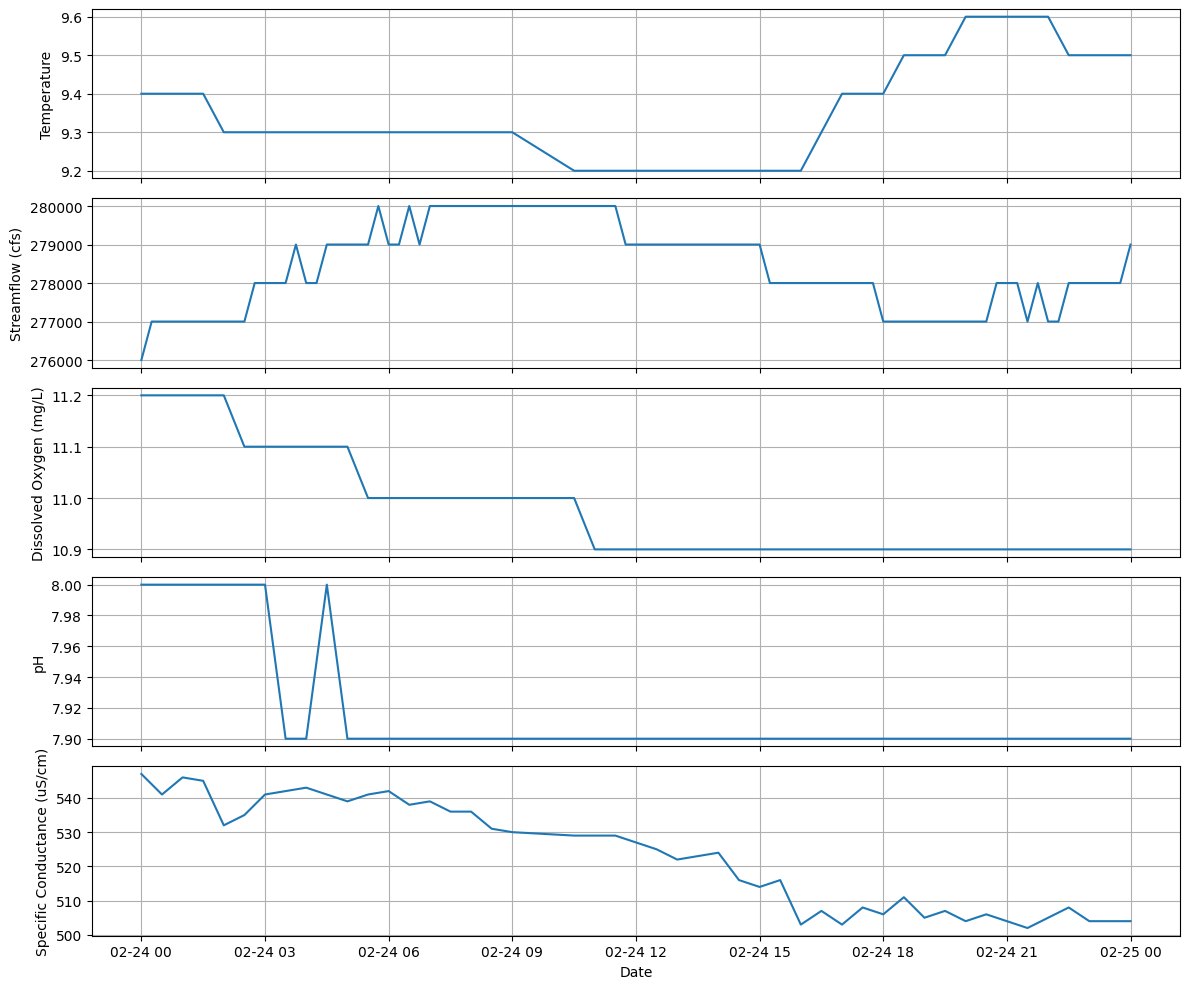

In [7]:
import matplotlib.pyplot as plt
from dataretrieval import waterdata

df_iv, _ = waterdata.get_continuous(
    monitoring_location_id='USGS-07374000',
    parameter_code=['00010','00060','00095','00300','00400'],
    time=["2026-02-24","2026-02-25"]
)

# Pivot to wide format: one column per parameter
df_wide = df_iv.pivot(index='time', columns='parameter_code', values='value')

# Plot stacked subplots
fig, axes = plt.subplots(len(params), 1, figsize=(12, 10), sharex=True)

if len(params) == 1:
    axes = [axes]

for ax, (code, label) in zip(axes, params.items()):
    if code in df_wide.columns:
        series = df_wide[code].dropna()
        ax.plot(series.index, series)
    ax.set_ylabel(label)
    ax.grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

**Cleaning Data**


In [8]:
df_wide.columns = df_wide.columns.map(params)

required_cols = [col for col in df_wide.columns]
df_clean = df_wide.dropna(subset=required_cols, how='any')
df_clean.head()

parameter_code,Temperature,Streamflow (cfs),Specific Conductance (uS/cm),Dissolved Oxygen (mg/L),pH
time,,,,,
2026-02-24 00:00:00+00:00,9.4,276000.0,547.0,11.2,8.0
2026-02-24 00:30:00+00:00,9.4,277000.0,541.0,11.2,8.0
2026-02-24 01:00:00+00:00,9.4,277000.0,546.0,11.2,8.0
2026-02-24 01:30:00+00:00,9.4,277000.0,545.0,11.2,8.0
2026-02-24 02:00:00+00:00,9.3,277000.0,532.0,11.2,8.0
